/data/kirg/MMVAE/cigale/20260103185816/epochs/SpectraVAE/weights_epoch_150.weights.h5 /data/kirg/MMVAE/cigale/20260103185816/epochs/BandPassVAE/weights_epoch_150.weights.h5 /data/kirg/MMVAE/cigale/20260103185816/epochs/ParamVAE/weights_epoch_150.weights.h5


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1334']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1350']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1334']
Received: inputs=Tensor(shape=(100000, 100))
  warnings.warn(msg)
/tmp/ipykernel_1112321/1584048518.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


0.036360398


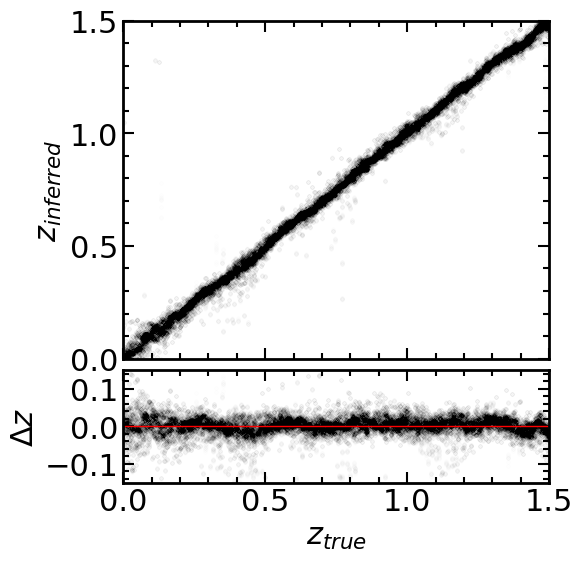

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1350']
Received: inputs=Tensor(shape=(100000, 5))
  warnings.warn(msg)
/tmp/ipykernel_1112321/1584048518.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


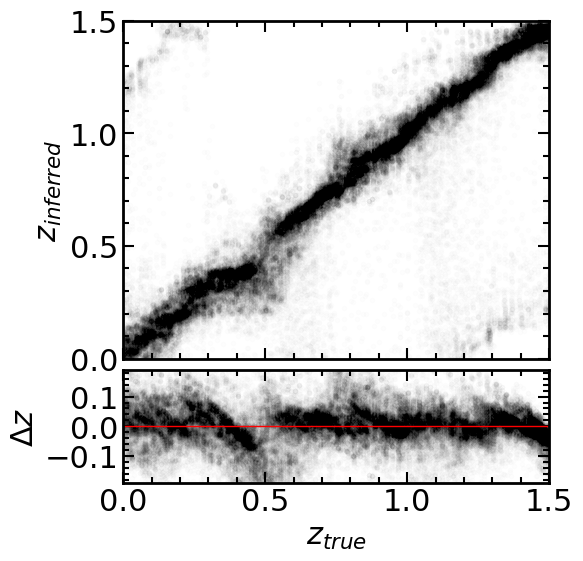

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import corner
from astropy.io import fits
from astropy.table import Table, vstack
from ParamVAEapply import ParamVAEapply
from BandPassVAE import BandPassVAE
from SpectraVAE import SpectraVAE
from ParamVAE import ParamVAE
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import numpy.ma as ma
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from utils import Sampling
from astropy.stats import sigma_clip
import matplotlib
import matplotlib.gridspec as gridspec

matplotlib.rcParams.update({'font.size': 22})


def load_paramvaeapply(path: str, weight_file: str, input_dim: int, latent_dim: int, beta: float) -> ParamVAEapply:
    """
    Loads weights and builds a ParamVAEapply model from a saved epoch weight file.

    Parameters:
        weight_file (str): Path to the weights file (.h5).
        input_dim (int): Dimensionality of the input data.
        latent_dim (int): Latent space dimensionality.
        beta (float): Beta value for VAE loss.

    Returns:
        ParamVAEapply: A ready-to-use model with loaded weights.
    """
    # Build required submodels
    
    spvae_wf = os.path.join(os.path.join(path, 'SpectraVAE'), weight_file)
    bpvae_wf = os.path.join(os.path.join(path, 'BandPassVAE'), weight_file)
    parvae_wf = os.path.join(os.path.join(path, 'ParamVAE'), weight_file)
    print(spvae_wf, bpvae_wf, parvae_wf)
    spvae = SpectraVAE(100, latent_dim, beta=beta)
    spvae.compile() #optimizer=keras.optimizers.Adam())
    spvae(tf.zeros((1, 100)))  # Force model building
    spvae.load_weights(spvae_wf)

    bpvae = BandPassVAE(input_dim, latent_dim, spvae, beta=beta)
    bpvae.compile()#optimizer=keras.optimizers.Adam())
    bpvae(tf.zeros((1, input_dim)))  # Force model building
    bpvae.load_weights(bpvae_wf)

    # Attach ParamVAE
    parvae = ParamVAE(100, latent_dim, spvae, beta=beta, n_param=4)
    parvae.compile()#optimizer=keras.optimizers.Adam())
    parvae(tf.zeros((1, 100)))  # Force model building
    parvae.load_weights(parvae_wf)

    return ParamVAEapply(input_dim, latent_dim, bpvae, parvae, beta=beta), parvae, bpvae, spvae


latent_dim = 8 #64
beta = 1e-3
epoch = 1
n_param = 4
input_dim = 5
epoch = 150

chunk_size = 100_000      # user-defined chunk size
n_smpl = 10               # number of model samples per chunk

#id_run = '20251010162214'
id_run = '20260103185816'
weight_path = "/data/kirg/MMVAE/cigale/" + id_run + "/"
save_path = os.path.join(weight_path, 'epochs/')
plot_output_path = os.path.join(weight_path, 'cornerplots_train_' + id_run)


tr_smpl = os.path.join(weight_path, 'train_dataset_cigale_tmpl.fits')

weight_file = f"weights_epoch_{epoch:02d}.weights.h5"
parvaeapply, parvae, bpvae, spvae = load_paramvaeapply(
    save_path, weight_file, input_dim, latent_dim, beta
)



t = Table.read(tr_smpl)

inp_spec = t['Spec']
inp_sed = t['SED']
inp_par = t['Param']

inp_spec_sel = inp_spec

spec_applied = parvae(inp_spec_sel)

ztrue = inp_par[:, 0]
zest = spec_applied[:, 0]

print(np.std((zest - ztrue) / (1 + ztrue)))

residual = zest - ztrue

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05, wspace=0, left=0.19)

# Top panel
ax1 = fig.add_subplot(gs[0])
ax1.plot(ztrue, zest, 'k.', alpha=0.005)
ax1.set_ylabel(r'$z_{inferred}$')
ax1.set_xlim(0, 1.5)
ax1.set_ylim(0, 1.5)
ax1.tick_params(labelbottom=False)

# Bottom panel (shared x-axis)
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(ztrue, residual, 'k.', alpha=0.005)
ax2.axhline(0, color='r', lw=1)
ax2.set_xlabel(r'$z_{true}$')
ax2.set_ylabel(r'$\Delta z$')
ax2.set_xlim(0, 1.5)
ax2.set_ylim(-0.15, 0.15)

# Turn on minor ticks
ax1.minorticks_on()
ax2.minorticks_on()

# Put ticks inside and show them on all sides
for ax in [ax1, ax2]:
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.tick_params(which='major', length=8, width=1.5)
    ax.tick_params(which='minor', length=4, width=1.5)

for spine in ax1.spines.values():
    spine.set_linewidth(2)

for spine in ax2.spines.values():
    spine.set_linewidth(2)


plt.tight_layout()
plt.savefig(f'z_qual_train_spec_{id_run}.png')

plt.show()


inp_phot_sel = inp_sed[1000:1100]
phot_applied = parvaeapply(inp_sed)

ztrue = inp_par[:, 0]
zest = phot_applied[:, 0]

residual = zest - ztrue

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05, wspace=0, left=0.19)

# Top panel
ax1 = fig.add_subplot(gs[0])
ax1.plot(ztrue, zest, 'k.', alpha=0.007)
ax1.set_ylabel(r'$z_{inferred}$')
ax1.set_xlim(0, 1.5)
ax1.set_ylim(0, 1.5)
ax1.tick_params(labelbottom=False)

# Bottom panel (shared x-axis)
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(ztrue, residual, 'k.', alpha=0.007)
ax2.axhline(0, color='r', lw=1)
ax2.set_xlabel(r'$z_{true}$')
ax2.set_ylabel(r'$\Delta z$')
ax2.set_xlim(0, 1.5)
ax2.set_ylim(-0.19, 0.19)

# Turn on minor ticks
ax1.minorticks_on()
ax2.minorticks_on()

# Put ticks inside and show them on all sides
for ax in [ax1, ax2]:
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.tick_params(which='major', length=8, width=1.5)
    ax.tick_params(which='minor', length=4, width=1.5)



for spine in ax1.spines.values():
    spine.set_linewidth(2)

for spine in ax2.spines.values():
    spine.set_linewidth(2)


plt.tight_layout()
plt.savefig(f'z_qual_train_phot_{id_run}.png')

plt.show()
